In [1]:
import torch
import numpy as np
import pyvista as pv
import Ofpp
from utils.visualizer import *
pv.set_jupyter_backend('static') 

import sys
import os
sys.path.insert(0, r'C:\Users\Noahc\Documents\USYD\PHD\8 - Github\Torch_VFM')
from src.utils.mesh_utils import *
from src.utils.data_utils import get_bc_dict
from src.gauss_green import gaus_green_vfm_mesh
from src.physics.operators import *

In [2]:
from src.physics.navier_stokes_fvm import *
from src.utils.data_utils import get_bc_dict

In [3]:
dir = r'C:\Users\Noahc\Downloads\c5_test\case.foam'
vtk_file_reader = pv.POpenFOAMReader(dir)
dtype = torch.float32

# Get Mesh
mesh = gaus_green_vfm_mesh(vtk_file_reader, dtype=dtype)
mesh.add_bc_conditions(get_bc_dict())

Calculating face centers and areas for 37020 faces
Corrected 0 misaligned face area vectors
{'max_non_orthogonality': 43.4339485168457, 'avg_non_orthogonality': 4.755862236022949, 'max_skewness': 0.19769421219825745, 'avg_skewness': 0.005930544808506966}
 Found Patch "out" with 80 Faces
 Found Patch "sym1" with 100 Faces
 Found Patch "sym2" with 100 Faces
 Found Patch "in" with 80 Faces
 Found Patch "cylinder" with 80 Faces
 Found Patch "back" with 9200 Faces
 Found Patch "front" with 9200 Faces
Boundary faces indexed: 18840/18840 patches found
Calculating Cell2Cell at Face Linear Interpolation Weights (L2):
  min w:0.4621,               max w:0.5837,               mean w:0.5050
resorting to default bc_dict, this line needs to be superseeded


In [4]:
# Initialize PDE Controller
config = {'mesh_file_pointer': r'C:\Users\Noahc\Downloads\c5_test',
            'enforcement_list': ['Continuity Loss', 'IC Loss'],
            'equations_limiters' : {'Continuity Loss' : 0.001
                },
            'dataset_channels' : {'U': [0,1],
                                'p': [2]
                                },
            'length_scale' : 2,
            'pde_equation' : 'navier_stokes_2d',
            'settings': {
            'verbose':                False,
            'ic_loss':                True,
            'pin_first_ts':           True,
            'pde_loss':               True,
            'mom_eqn_skip_first_ts':  False,
            'soblov_norms':           False   # Not Implemented yet
            },
            'enforcement_list': ['IC Loss'],
            'equations_limiters': {}
        }

In [5]:
field_channel_idx_dict = config['dataset_channels']

In [6]:
U = torch.tensor(Ofpp.parse_internal_field(r'C:\Users\Noahc\Downloads\c5_test\30.3\U'),dtype=dtype).unsqueeze(0).unsqueeze(0)
U_t0 = torch.tensor(Ofpp.parse_internal_field(r'C:\Users\Noahc\Downloads\c5_test\30.25\U'),dtype=dtype).unsqueeze(0).unsqueeze(0)
U_t00 = torch.tensor(Ofpp.parse_internal_field(r'C:\Users\Noahc\Downloads\c5_test\30.2\U'),dtype=dtype).unsqueeze(0).unsqueeze(0)
dt_real = 0.05

In [9]:
nu = 0.013333333333333334
Re = 1/nu #non-normalized
Re = torch.tensor(Re,dtype=dtype).reshape(1,1,1,1)

In [10]:
equation_list = navier_stokes_3d(mesh, solution_field=U, solution_index=field_channel_idx_dict, Re=Re, time_derivative=0)

In [11]:
dt = Temporal_Differentiator.caclulate(U, time_step=dt_real, input_solution=torch.cat([U_t00,U_t0], dim = 1), method='backwards')
dt.shape

torch.Size([1, 1, 9200, 3])

In [12]:
dt.shape

torch.Size([1, 1, 9200, 3])

In [13]:
equation_list = navier_stokes_3d(mesh, solution_field=U, solution_index=field_channel_idx_dict, Re=Re, time_derivative=dt)

In [14]:
grad_u_real = torch.tensor(Ofpp.parse_internal_field(r'C:\Users\Noahc\Downloads\c5_test\30.3\grad(U)'),dtype=dtype)

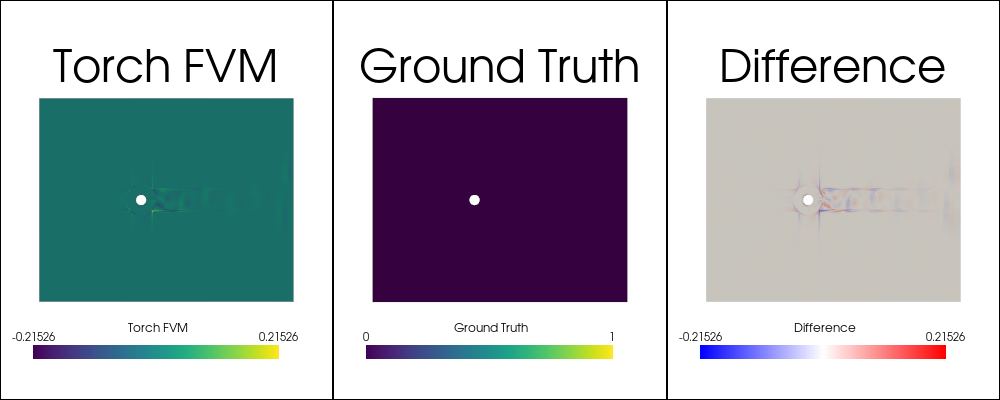

In [15]:
plot_comparison(mesh.vtk_mesh, None, f'None',i=0, interactive = True, point_label=False,
                    prediction=grad_u_real[...,[0]]+grad_u_real[...,[4]],
                    ground_truth = torch.zeros_like(equation_list['Continuity'][0,0,...].unsqueeze(-1)),
                    #clims3=[-0.00001,0.00001],
                    zoom=False
                    )

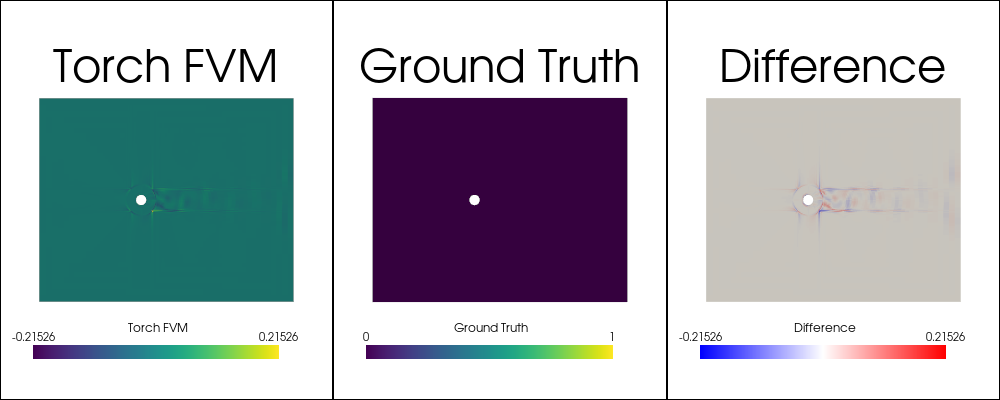

In [16]:
plot_comparison(mesh.vtk_mesh, None, f'None',i=0, interactive = True, point_label=False,
                    prediction=equation_list['Continuity'][0,0,...].unsqueeze(-1),
                    ground_truth = torch.zeros_like(equation_list['Continuity'][0,0,...].unsqueeze(-1)),
                    #clims3=[-0.00001,0.00001],
                    zoom=False
                    )

$$
\frac{U_{t+1} - U_t}{\Delta t} = -f(U_t)
$$

$$
\frac{U_t - U_{t+1}}{\Delta t} = - f(U_{t+1})
$$

$$
\frac{U_{t-1} - U_{t}}{\Delta t} = - f(U_{t})
$$

In [17]:
mom_eqn = torch.tensor(Ofpp.parse_internal_field(r'C:\Users\Noahc\Downloads\c5_test\30.3\UEqn'),dtype=dtype)

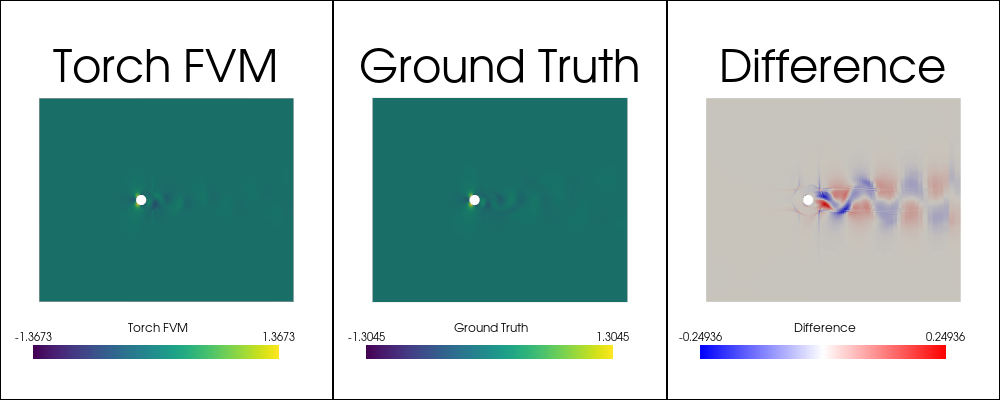

In [18]:
plot_comparison(mesh.vtk_mesh, None, f'None',i=0, interactive = True, point_label=False,
                    prediction=equation_list['X-momentum'][0,0,...].unsqueeze(-1).numpy(),
                    ground_truth = mom_eqn[:,[0]],
                    #clims3=[-0.00001,0.00001],
                    zoom=False
                    )

We can assume the difference is due to the uncorrected phi

comparing the Openfoam X-momentum Loss to zero

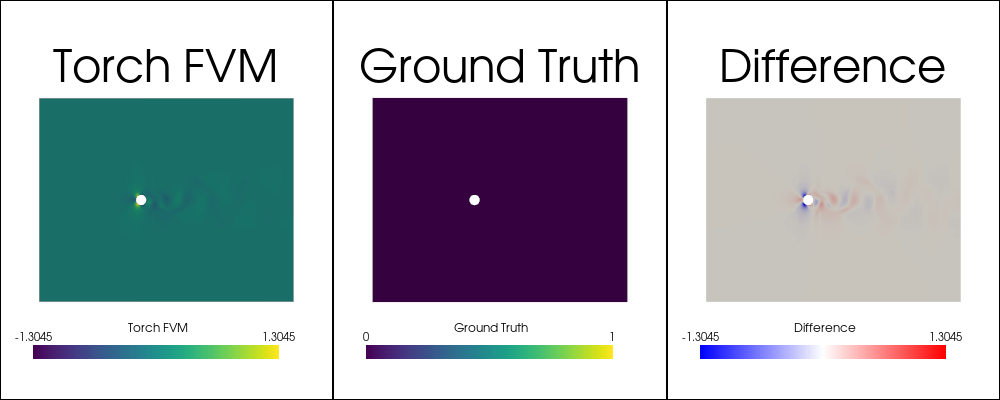

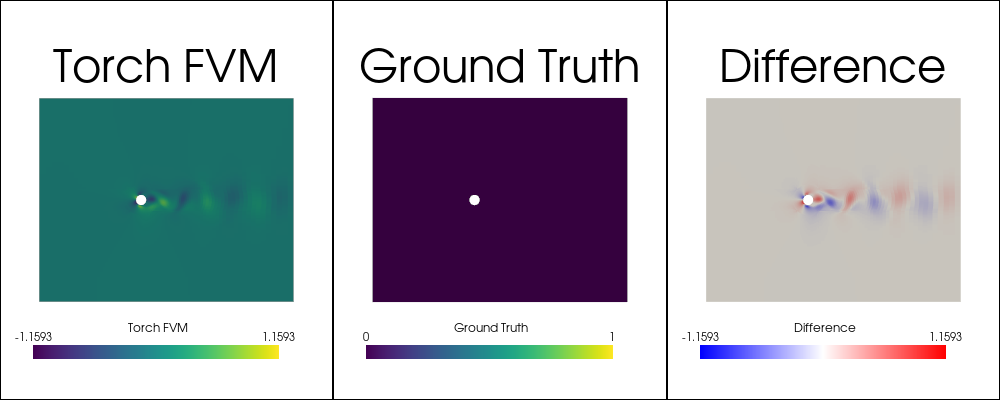

In [19]:
for i in range(2):
    plot_comparison(mesh.vtk_mesh, None, f'None',i=i, interactive = True, point_label=False,
                    prediction=mom_eqn,
                    ground_truth = torch.zeros_like(mom_eqn),
                    #clims3=[-0.00001,0.00001],
                    zoom=False
                    )

Comparing the torch solution to zero

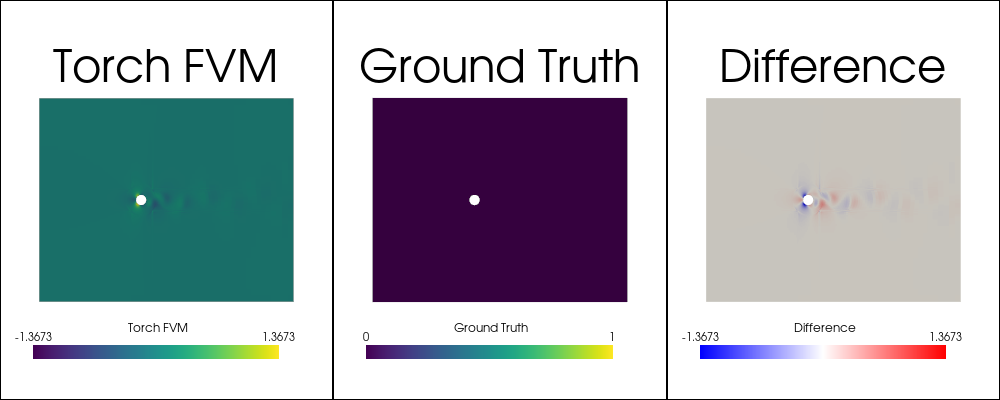

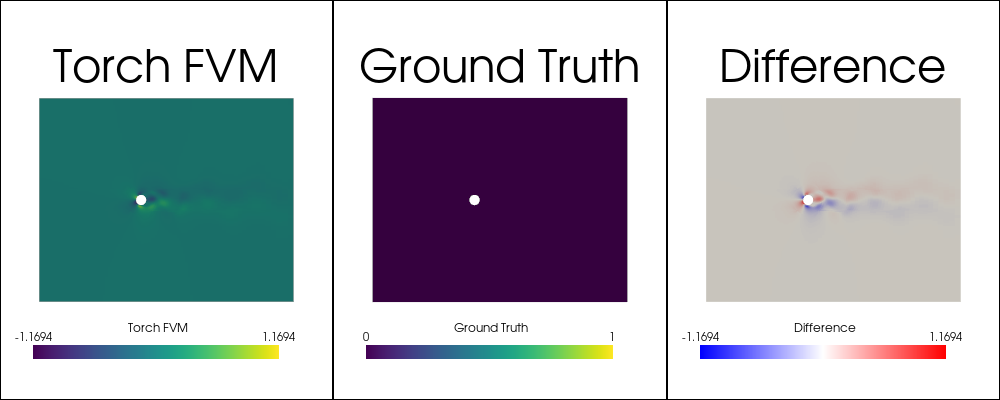

In [20]:
for i in ['X-momentum', 'Y-momentum']:
    plot_comparison(mesh.vtk_mesh, None, f'None',i=0, interactive = True, point_label=False,
                    prediction=equation_list[i][0,0,...].unsqueeze(-1),
                    ground_truth = torch.zeros_like(equation_list[i][0,0,...].unsqueeze(-1)),
                    #clims3=[-0.00001,0.00001],
                    zoom=False
                    )

## Pipeline Test

In [21]:
from src.gauss_green import gaus_green_vfm_mesh
from src.pde_controller_v2 import pde_controller

In [22]:
config = {'mesh_file_pointer': r'C:\Users\Noahc\Downloads\c5_test\case.foam',
            'enforcement_list': ['Continuity Loss', 'IC Loss'],
            'equations_limiters' : {'Continuity Loss' : 0.001
                },
            'dataset_channels' : {'U': [0,1],
                                'p': [2]
                                },
            'length_scale' : 2,
            'pde_equation' : 'navier_stokes_2d',
            'settings': {
                'verbose':                False,
                'ic_loss':                True,
                'pin_first_ts':           True,
                'pde_loss':               True,
                'mom_eqn_skip_first_ts':  False,
                'soblov_norms':           False,   # Not Implemented yet
                'dt_scheme':              'backwards'
            },
            'enforcement_list': ['IC Loss'],
            'equations_limiters': {}
        }

In [23]:
# def navier_stokes_3d(mesh, solution_field:torch.tensor, solution_index:dict, Re:torch.tensor, time_derivative:torch.tensor) -> torch.tensor:
#     '''
#     grad_dict should be a dictionary of tensors, with keys aligning to the following format:
#     dp/dx for scalars and for vectors
#     dU/dx are denoted as du/dx and dv/dy same with time derivates being du/dt and dv/dt
#     '''
#     dict_keys = ['Continuity',
#                  'X-momentum',
#                  'Y-momentum']
#     equations = dict.fromkeys(dict_keys)

#     assert len(Re.shape) == len(solution_field.shape), f'{Re.shape} vs {solution_field.shape}'
#     assert len(solution_field.shape) == 4, 'Solution field should be [batch, time-step, cells, channels]'

#     p = solution_field[...,solution_index['p']]
#     U = solution_field[...,solution_index['U']]
#     if U.shape[-1] == 2:
#         flag2d = True
#         U = torch.nn.functional.pad(U,(0,1))
#     else:
#         flag2d = False
    
#     advection_field, gradient_field = Divergence_Operator.caclulate(mesh,U,field_type = 'U')
#     _, pressure_gradient            = Divergence_Operator.caclulate(mesh,p,field_type = 'p')
#     laplacian_field                 = Laplacian_Operator.caclulate(mesh,U,field_type = 'U', 
#                                                                    gradient_field=gradient_field, 
#                                                                    correction_method=mesh.correction_method)
#     print(advection_field.shape, pressure_gradient.shape, laplacian_field.shape, )
#     dudx = gradient_field[...,0]
#     dvdy = gradient_field[...,4]
#     dwdz = gradient_field[...,8]

#     # Equations
#     momentum_equations = time_derivative + advection_field -(1/Re)*laplacian_field + pressure_gradient
#     equations['X-momentum'] = momentum_equations[...,0]
#     equations['Y-momentum'] = momentum_equations[...,1]

#     if flag2d:
#         equations['Continuity'] = dudx + dvdy
#     else: 
#         equations['Continuity'] = dudx + dvdy + dwdz
#         equations['Z-momentum'] = momentum_equations[...,2]


#     return equations

In [24]:


# Control Arguments:
model_ckpt_path = None
epochs = 1

# Save Path:
# script_dir = os.path.dirname(os.path.abspath(__file__))
# base_dir = '\\'.join(os.path.split(script_dir))
# save_dir = base_dir+'/results/mock_model'

print('Creating PDE Controller')
pde_controller = pde_controller(config=config)
print('PDE Controller created')

Creating PDE Controller
Calculating face centers and areas for 37020 faces
Corrected 0 misaligned face area vectors
{'max_non_orthogonality': 43.4339485168457, 'avg_non_orthogonality': 4.755862236022949, 'max_skewness': 0.19769421219825745, 'avg_skewness': 0.005930544808506966}
 Found Patch "out" with 80 Faces
 Found Patch "sym1" with 100 Faces
 Found Patch "sym2" with 100 Faces
 Found Patch "in" with 80 Faces
 Found Patch "cylinder" with 80 Faces
 Found Patch "back" with 9200 Faces
 Found Patch "front" with 9200 Faces
Boundary faces indexed: 18840/18840 patches found
Calculating Cell2Cell at Face Linear Interpolation Weights (L2):
  min w:0.4621,               max w:0.5837,               mean w:0.5050
resorting to default bc_dict, this line needs to be superseeded
PDE Controller created


In [25]:
# In this case the mesh has already an openfoam solution, so we can use that instead of creating
# a dataloader -> Remember Data is already in 3d
file_reader = pde_controller.vtk_file_reader

# at t0 - Input Solution (batch, time, cells, channels)
file_reader.set_active_time_value(file_reader.time_values[-1])
mesh = file_reader.read()[0]
U = torch.tensor(mesh['U'],dtype=torch.float32)[...,:2] # for 2D
p = torch.tensor(mesh['p'],dtype=torch.float32).unsqueeze(-1)
x_i = torch.cat([U,p],dim=-1).unsqueeze(0).unsqueeze(0)

# at t1 - Output Solution (batch, time, cells, channels)
file_reader.set_active_time_value(file_reader.time_values[-1])
mesh = file_reader.read()[0]
U = torch.tensor(mesh['U'],dtype=torch.float32)[...,:2] # for 2D
p = torch.tensor(mesh['p'],dtype=torch.float32).unsqueeze(-1)
y = torch.cat([U,p],dim=-1).unsqueeze(0).unsqueeze(0)

# Model Inputs (batch, cells, space dims)
x = torch.tensor(mesh.cell_centers().points,dtype=torch.float32).unsqueeze(0)[...,:2]
print('Dataset created')

# Initialize a Network
model = torch.nn.Sequential(torch.nn.Linear(2, 64),
                                    torch.nn.ReLU(),
                                    torch.nn.Linear(64, 128),
                                    torch.nn.ReLU(),
                                    torch.nn.Linear(128, 128),
                                    torch.nn.ReLU(),
                                    torch.nn.Linear(128, 128),
                                    torch.nn.ReLU(),
                                    torch.nn.Linear(128, 128),
                                    torch.nn.ReLU(),
                                    torch.nn.Linear(128, 128),
                                    torch.nn.ReLU(),
                                    torch.nn.Linear(128, 128),
                                    torch.nn.ReLU(),
                                    torch.nn.Linear(128, 64),
                                    torch.nn.ReLU(),
                                    torch.nn.Linear(64, 3),
                                    torch.nn.ReLU()
                                    )
print('Model initialized')

if model_ckpt_path:
    # Load Checkpoint and Evaluate Immediately
    checkpoint = torch.load(model_ckpt_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f'loaded model weights from {model_ckpt_path}')
else:
    # Train new model
    print(f'Training fresh new model for {epochs} epochs')
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_function = torch.nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, total_steps=1000)

    for epoch in range(epochs):
        optimizer.zero_grad()  # Clear gradients
        out = model(x).unsqueeze(0)
        loss = loss_function(out, y)
        eqn_loss = pde_controller.compute(out, y, input_solution=x_i, time_step=0.05)
        loss += eqn_loss
        loss.backward()       # Compute gradients
        optimizer.step()      # Update weights using Adam
        scheduler.step()
        print(f'epoch: {epoch:3} loss: {loss.item():6.4}')  

    checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
            'loss': loss
        }

Dataset created
Model initialized
Training fresh new model for 1 epochs
epoch:   0 loss: 0.3476
